In [39]:
img_size = 64
batch = 1
batch_size_2 = 32
hidden_units = 16
epochs=10

trivialAugmentWide_magnitude=31

## Load Data

In [40]:
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [41]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
image_path = Path("data/") / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(Path("data/") / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(Path("data/") / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


# Know your data and Transform

In [42]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)
train_dir = image_path / "train"
test_dir = image_path / "test"

There are 2 directories and 1 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [43]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize(size = (img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.TrivialAugmentWide(num_magnitude_bins=trivialAugmentWide_magnitude),
    transforms.ToTensor()
])

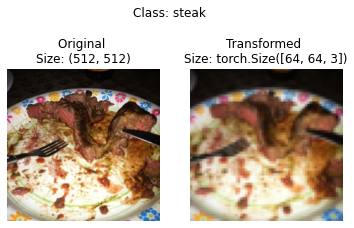

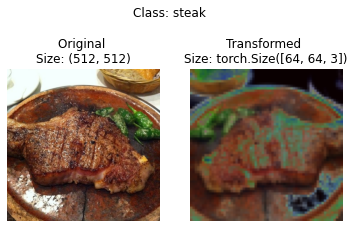

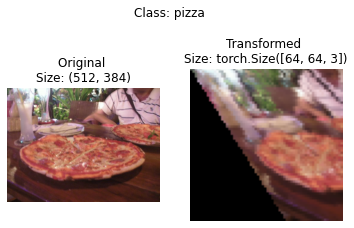

In [44]:
#Plot images
image_path_list = list(image_path.glob("*/*/*.jpg"))
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1,2)
      ax[0].imshow(f) 
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis("off")

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image) 
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}")

plot_transformed_images(image_path_list,transform=data_transform, )

# Make Dataset

In [45]:
train_data = datasets.ImageFolder(root = train_dir, transform = data_transform, target_transform=None)
test_data = datasets.ImageFolder(root = test_dir, transform = data_transform, target_transform=None)
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [46]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size = batch, num_workers=os.cpu_count(), shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size = batch, num_workers = os.cpu_count(), shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fd2b8f7acd0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd2b8f7ac40>)

# Make Model

In [47]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = batch_size_2
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7fd2b8f104f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fd2b8f99490>)

In [48]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(hidden_units*16*16, output_shape)
    )

  def forward(self, x):
    return self.classifier(self.block_2(self.block_1(x)))

model = TinyVGG(3, hidden_units, len(class_names)).to(device)
model

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=3, bias=True)
  )
)

In [49]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 64, 64]           448
│    └─ReLU: 2-2                         [1, 16, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 16, 64, 64]           2,320
│    └─ReLU: 2-4                         [1, 16, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-7                         [1, 16, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 16, 32, 32]           2,320
│    └─ReLU: 2-9                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 16, 16, 16]           --
├─Seq

In [50]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
  model.train()
  train_acc, train_loss = 0,0
  for batch, (x,y) in enumerate(dataloader):
    x,y = x.to(device), y.to(device)
    pred_logit = model(x)

    loss = loss_fn(pred_logit,y)
    train_loss+=loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pred_class = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

    train_acc+=(pred_class==y).sum().item()/len(pred_logit)
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [51]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
  model.eval()
  test_loss, test_acc = 0,0
  with torch.inference_mode():
    for batch, (x,y) in enumerate(dataloader):
      x,y=x.to(device), y.to(device)

      pred_logit = model(x)
      loss = loss_fn(pred_logit, y)
      test_loss+=loss.item()

      pred_class = pred_logit.argmax(dim=1)
      test_acc+=(pred_class==y).sum().item()/len(pred_class)
  test_loss = test_loss / len(dataloader)
  tesst_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [52]:
from tqdm.auto import tqdm

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer):
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    for epoch in range(epochs):
      train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
      test_loss, test_acc = test_step(model, test_dataloader, loss_fn)
      print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
    return results

In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Epoch: 1 | train_loss: 1.1065 | train_acc: 0.2461 | test_loss: 1.1062 | test_acc: 0.7812
Epoch: 2 | train_loss: 1.0860 | train_acc: 0.4258 | test_loss: 1.1249 | test_acc: 0.7812
Epoch: 3 | train_loss: 1.0794 | train_acc: 0.4258 | test_loss: 1.1542 | test_acc: 0.7812
Epoch: 4 | train_loss: 1.1173 | train_acc: 0.3047 | test_loss: 1.1500 | test_acc: 0.7812
Epoch: 5 | train_loss: 1.0689 | train_acc: 0.4258 | test_loss: 1.1279 | test_acc: 0.7812
Epoch: 6 | train_loss: 1.1345 | train_acc: 0.3047 | test_loss: 1.1300 | test_acc: 0.7812
Epoch: 7 | train_loss: 1.0647 | train_acc: 0.5273 | test_loss: 1.1280 | test_acc: 0.6875
Epoch: 8 | train_loss: 1.0949 | train_acc: 0.3750 | test_loss: 1.1341 | test_acc: 0.7812
Epoch: 9 | train_loss: 1.0858 | train_acc: 0.4531 | test_loss: 1.1041 | test_acc: 0.8125
Epoch: 10 | train_loss: 1.0250 | train_acc: 0.3906 | test_loss: 1.0577 | test_acc: 0.9915
Total training time: 16.344 seconds


# Model Performance

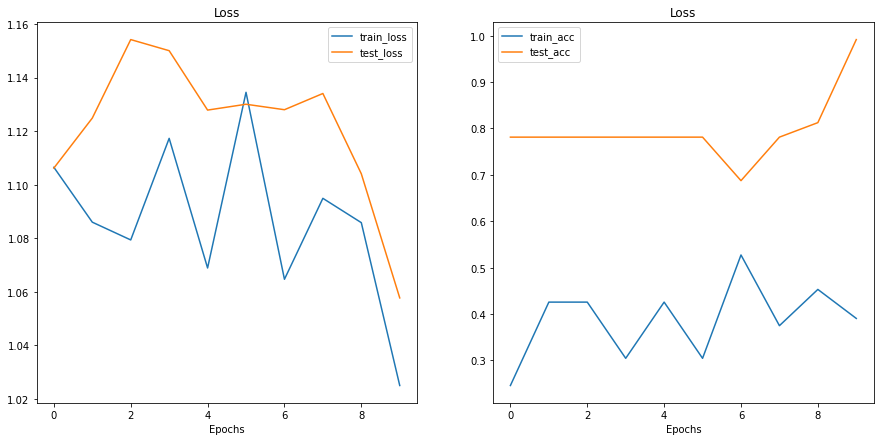

In [54]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  acc = results["train_acc"]
  test_acc = results["test_acc"]
  epochs_num = range(len(results['train_loss']))
  plt.figure(figsize=(15,7))

  #plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs_num, loss, label='train_loss')
  plt.plot(epochs_num, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #plot acc
  plt.subplot(1,2,2)
  plt.plot(epochs_num, acc, label='train_acc')
  plt.plot(epochs_num, test_acc, label='test_acc')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

plot_loss_curves(model_results)

In [55]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


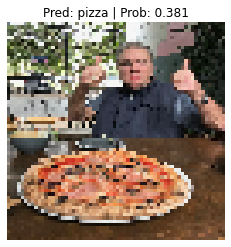

In [57]:
# Download custom image
import requests
import torchvision

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)